### TODO: architecture
### TODO: stratified k-fold: dataset
### TODO: evaluation: metrics

In [1]:
import os
import json
import torch
import pickle
import numpy as np
from PIL import Image, ImageFilter 
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



cuda:0


In [6]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 kB 1.8 MB/s eta 0:00:0000:0100:01
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ijpuu202
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ijpuu202
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=a85bddd7576421df8d4a47f3fc8b23242e57635de767b5b996199985ebfe00c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-m6uyuun0/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


## Load the data from RefCOCOg

Here we load the annotation file with all the references and the images. 

In [4]:
with open("../extractCOCO/refcocog/annotations/refs(umd).p", "rb") as fp:
  annotations = pickle.load(fp)

  train_data = sorted([d for d in annotations if d["split"]=="train"], key=lambda d: d["file_name"])
  val_data = sorted([d for d in annotations if d["split"]=="val"], key=lambda d: d["image_id"])
  test_data = sorted([d for d in annotations if d["split"]=="test"], key=lambda d: d["image_id"])

  entry = train_data[0]

  print(json.dumps(entry, indent=4, default=str))



{
    "image_id": 9,
    "split": "train",
    "sentences": [
        {
            "tokens": [
                "a",
                "yellow",
                "rectangle",
                "bowl",
                "with",
                "broccoli",
                "and",
                "a",
                "brown",
                "food",
                "in",
                "it"
            ],
            "raw": "a yellow rectangle bowl with broccoli and a brown food in it",
            "sent_id": 92713,
            "sent": "a yellow rectangle bowl with broccoli and a brown food in it"
        },
        {
            "tokens": [
                "the",
                "tray",
                "that",
                "holds",
                "the",
                "broccoli"
            ],
            "raw": "The tray that holds the broccoli.",
            "sent_id": 92714,
            "sent": "the tray that holds the broccoli"
        }
    ],
    "file_name": "COCO_train2014_00000000

Here the data loader class.

In [2]:
import os
import json

from torch.utils.data import Dataset

class RefCOCOg(Dataset):
    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": elem["sentences"][0]["raw"],
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]
    
    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

In [3]:
# Load refs and annotations
import pickle

with open("../extractCOCO/refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

with open("../extractCOCO/refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

In [4]:
# load the train dataset
train_dataset = RefCOCOg(refs=refs, annotations=annotations, split="train")

print(train_dataset[0])
print(train_dataset)
print(len(train_dataset))
train_dataset(0)

{'file_name': './refcocog/images/COCO_train2014_000000519404.jpg', 'caption': 'Two woman one in black eatting and the other has a white shirt at the desk', 'ann_id': 1241542, 'bbox': [0.0, 45.95, 238.92, 408.64]}
42226
{
    "file_name": "./refcocog/images/COCO_train2014_000000519404.jpg",
    "caption": "Two woman one in black eatting and the other has a white shirt at the desk",
    "ann_id": 1241542,
    "bbox": [
        0.0,
        45.95,
        238.92,
        408.64
    ]
}


# DINOv2 

In [18]:
# downloaded DINOV2 

# https://dinov2.metademolab.com/
# paper: https://arxiv.org/abs/2304.07193

dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /home/rickbook/.cache/torch/hub/main.zip
xFormers not available
xFormers not available
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /home/rickbook/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [04:34<00:00, 1.26MB/s] 


In [29]:
%%time
dinov2_vitb14(image).shape

CPU times: user 1.31 s, sys: 250 ms, total: 1.56 s
Wall time: 260 ms


torch.Size([1, 768])

In [ ]:
model, preprocess = clip.load("RN50", device=device)

In [25]:
%%time
image = preprocess(Image.open('../extractCOCO/'+train_dataset[0]["file_name"][1:])).unsqueeze(0).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)

# CLIP still be faster than DINOV2
# however, DINOV2 is more accurate 
# than CLIP in feature extraction

CPU times: user 457 ms, sys: 3.17 ms, total: 460 ms
Wall time: 81.9 ms


In [31]:
model, preprocess = clip.load("ViT-B/16", device=device)

100%|███████████████████████████████████████| 335M/335M [03:07<00:00, 1.87MiB/s]


In [34]:
%%time
image = preprocess(Image.open('../extractCOCO/'+train_dataset[0]["file_name"][1:])).unsqueeze(0).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)

# CLIP still be faster than DINOV2
# however, DINOV2 is more accurate 
# than CLIP in feature extraction

CPU times: user 928 ms, sys: 15.2 ms, total: 943 ms
Wall time: 163 ms


load detr and get the boxes

In [10]:


# source: https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_demo.ipynb#scrollTo=Y6Jrz6xz71C0
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled


# load the model from the torch hub
Images = [Image.open('../extractCOCO/'+sample["file_name"][1:]) for sample in train_dataset[:10]]
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)

Using cache found in /home/rickbook/.cache/torch/hub/facebookresearch_detr_main
/home/rickbook/mambaforge/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rickbook/mambaforge/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
scores, boxes = detect(Images[9], model, transform)

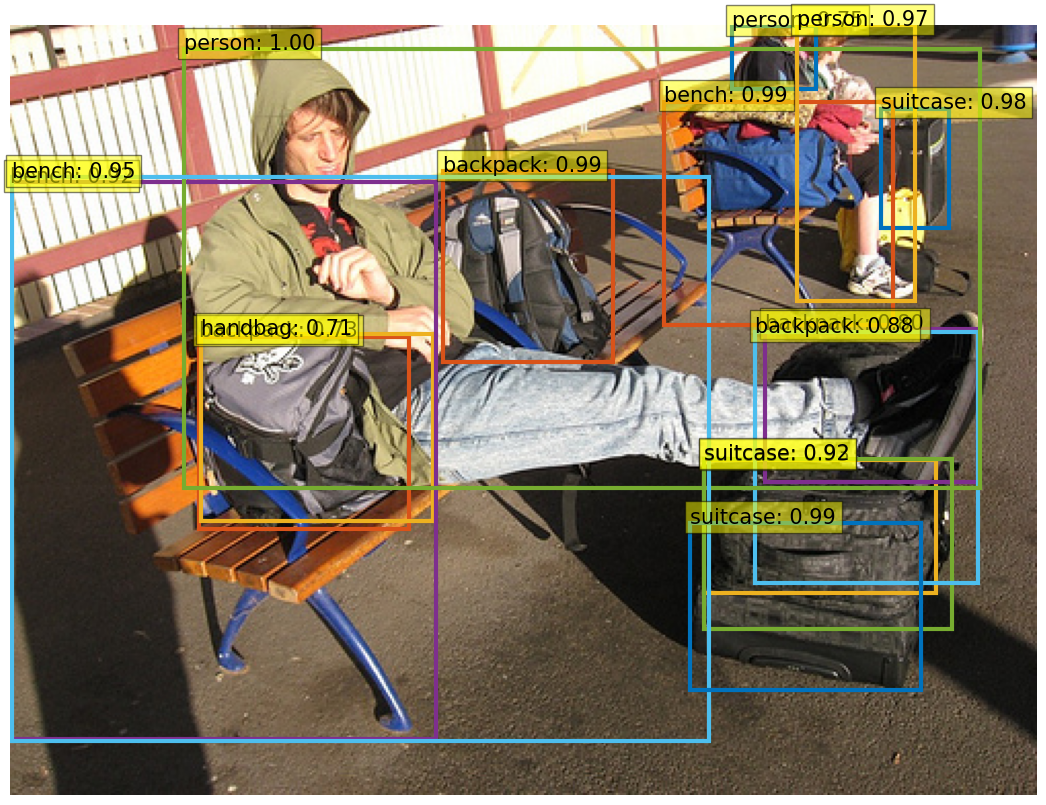

In [17]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

plot_results(Images[9], scores, boxes)

In [ ]:
# https://jamesmccaffrey.wordpress.com/2022/03/04/contrastive-loss-function-in-pytorch/
# contrastive loss function

# DINOv2 feature extractor  

I have made some tests on the DINOv2 model extracting the feature from the images. The extracted features are then used to measure the similarities in between images.

In [52]:

# metrics to mesure the distance between the tokenized caption
import numpy as np
import torch

""" 
"""

def euclidean_distance(u, v):
    """Computes the euclidean distance between two vectors.

    Args:
        u (torch.Tensor): feature vector of the first set of items
        v (torch.Tensor): feature vector of the second set of items

    Returns:
        float: euclidean distance between the two sets of items
    """
    return torch.sqrt(torch.sum((u - v) ** 2))

def cosine_similarity(u, v):
    """Computes the cosine similarity between two vectors.

    Args:
        u (torch.Tensor): feature vector of the first set of items
        v (torch.Tensor): feature vector of the second set of items

    Returns:    
        float: cosine similarity between the two sets of items

    """
    return torch.dot(u, v) / (torch.linalg.norm(u) * torch.linalg.norm(v))


# you do not have to preprocess the image with clip preprocessor
image1 = preprocess(Image.open('../extractCOCO/'+train_dataset[0]["file_name"][1:])).unsqueeze(0).to(device)
image2 = preprocess(Image.open('../extractCOCO/'+train_dataset[1]["file_name"][1:])).unsqueeze(0).to(device)


print(euclidean_distance(dinov2_vitb14(image1).detach(), dinov2_vitb14(image2).detach()))
print(cosine_similarity(dinov2_vitb14(image1).detach().squeeze(0), dinov2_vitb14(image2).detach().squeeze(0)))

image1 = preprocess(Image.open('../extractCOCO/'+train_dataset[3]["file_name"][1:])).unsqueeze(0).to(device)
image2 = preprocess(Image.open('../extractCOCO/'+train_dataset[100]["file_name"][1:])).unsqueeze(0).to(device)


print(euclidean_distance(dinov2_vitb14(image1).detach(), dinov2_vitb14(image2).detach()))
print(cosine_similarity(dinov2_vitb14(image1).detach().squeeze(0), dinov2_vitb14(image2).detach().squeeze(0)))

image1 = preprocess(Image.open('../extractCOCO/'+train_dataset[0]["file_name"][1:])).unsqueeze(0).to(device)
image2 = preprocess(Image.open('../extractCOCO/'+train_dataset[100]["file_name"][1:])).unsqueeze(0).to(device)


print(euclidean_distance(dinov2_vitb14(image1).detach(), dinov2_vitb14(image2).detach()))
print(cosine_similarity(dinov2_vitb14(image1).detach().squeeze(0), dinov2_vitb14(image2).detach().squeeze(0)))

image1 = preprocess(Image.open('../extractCOCO/'+train_dataset[0]["file_name"][1:])).unsqueeze(0).to(device)
image2 = preprocess(Image.open('../extractCOCO/'+train_dataset[0]["file_name"][1:])).unsqueeze(0).to(device)


print(euclidean_distance(dinov2_vitb14(image1).detach(), dinov2_vitb14(image2).detach()))
print(cosine_similarity(dinov2_vitb14(image1).detach().squeeze(0), dinov2_vitb14(image2).detach().squeeze(0)))

tensor(61.3338)
tensor(0.1048)
tensor(65.3171)
tensor(0.0706)
tensor(64.8901)
tensor(0.0277)
tensor(0.)
tensor(1.)


In [78]:
import numpy as np
import cv2

# distance between the same image preprocessed in different ways
image1_clip = preprocess(Image.open('../extractCOCO/'+train_dataset[0]["file_name"][1:])).unsqueeze(0).to(device)

image1 = cv2.imread('../extractCOCO/'+train_dataset[0]["file_name"][1:])
image1 = cv2.resize(image1, (224,224))
image1 = torch.from_numpy(np.array(image1)).permute(2, 0, 1).unsqueeze(0).type(torch.float32).to(device)


print(euclidean_distance(dinov2_vitb14(image1), dinov2_vitb14(image1_clip)))
print(cosine_similarity(dinov2_vitb14(image1).squeeze(0), dinov2_vitb14(image1_clip).squeeze(0)))



tensor(66.3671, grad_fn=<SqrtBackward0>)
tensor(0.0244, grad_fn=<DivBackward0>)


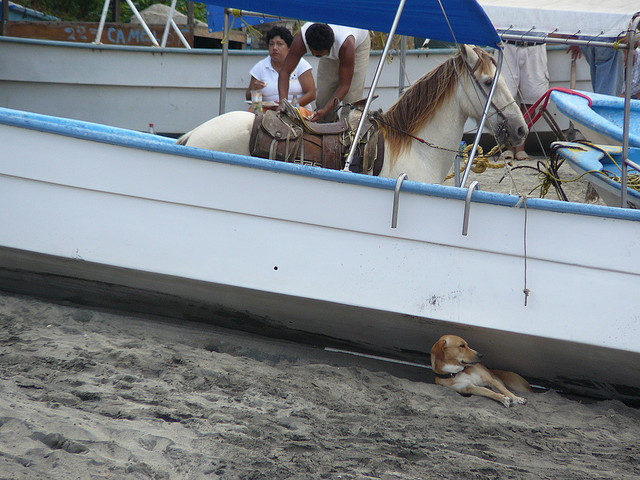

In [48]:
Image.open('../extractCOCO/'+train_dataset[100]["file_name"][1:])

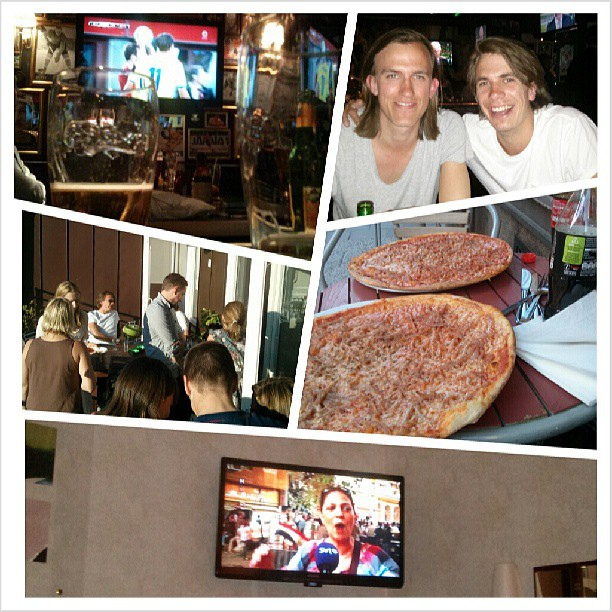

In [36]:
Image.open('../extractCOCO/'+train_dataset[1]["file_name"][1:])